# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')

import seaborn as sns
from matplotlib.pylab import plt
import time
import datetime
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jmgarzonv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\jmgarzonv\Desktop\EAFIT\MMDS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Configurations

In [2]:
class_names = ['fake', 'real'] # 0: fake, 1: real

# 3. Building Dataset

### Stemming

In [3]:
port = PorterStemmer()

def stemming(text):
    stem_text = re.sub('[^a-zA-Z]', ' ', text)
    stem_text = stem_text.lower()
    stem_text = stem_text.split()
    
    stem_text = [port.stem(word) for word in stem_text if not word in stopwords.words('english')]
    stem_text = ' '.join(stem_text)
    
    return stem_text

In [4]:
news_data = pd.read_csv('news_data_with_refined_tfidf.csv', sep=';')

In [5]:
news_data.head()

,Unnamed: 0,title,text,label,refined_tfidf
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,said
1,1,NaN,Did they post their votes for Hillary already?,1,alreadi hillari post vote
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,aka chang constitut creat demonstr eric exerci...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,jindal
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,design dub km mile missil rs sarmat satan weapon


In [20]:
labels = news_data['label'].values
news_data = news_data.fillna('')
texts = (news_data['title'] + ' ' + news_data['refined_tfidf']).values

### Tokenization

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [22]:
idx = np.random.choice(range(len(texts)))
print(texts[idx])
# Tokenized
print(tokenizer.tokenize(texts[idx]))
# Token to Integral
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[idx])))

Michael Bloomberg Names Technological Unemployment as the Next Administration’s “Greatest Conundrum”  
['michael', 'bloomberg', 'names', 'technological', 'unemployment', 'as', 'the', 'next', 'administration', '’', 's', '“', 'greatest', 'con', '##und', '##rum', '”']
[2745, 22950, 3415, 10660, 12163, 2004, 1996, 2279, 3447, 1521, 1055, 1523, 4602, 9530, 8630, 6824, 1524]


In [24]:
max_len = 0
id_len = []
for text in texts:
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    if len(input_ids) > 200:
        continue
    id_len.append(len(input_ids))
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  197


<Axes: >

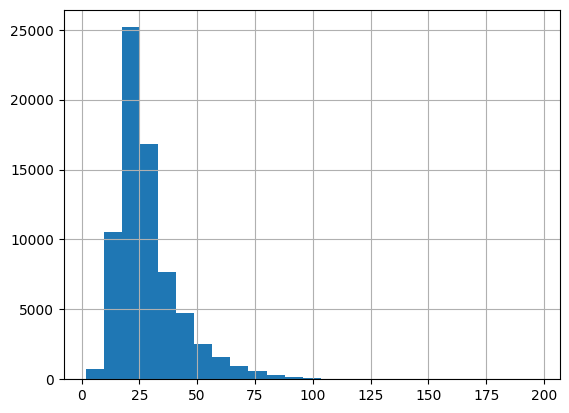

In [25]:
pd.Series(id_len).hist(bins=25)

In [26]:
def tokenize_map(sentence, labs='None'):
    global labels
    input_ids = []
    attention_masks = []
    for text in sentence:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens = True, # [CLS] & [SEP]
                            truncation = 'longest_first', # Control truncation
                            max_length = 100, # Max length about texts
                            pad_to_max_length = True, # Pad and truncate about sentences
                            return_attention_mask = True, # Attention masks
                            return_tensors = 'pt') # Return to pytorch tensors
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labs.any():
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [27]:
input_ids, attention_masks, labels = tokenize_map(texts, labels)

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
len(train_dataset.indices), len(val_dataset.indices)

c:\Users\jmgarzonv\Desktop\EAFIT\MMDS\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


(57707, 14427)

In [28]:
batch_size = 32
num_workers = 4

train_loader = DataLoader(
                dataset=train_dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=num_workers)

val_loader = DataLoader(
                dataset=val_dataset,
                batch_size=1,
                shuffle=False)

# 4. Loading Deep Learning Model

We used BERT for natural language processing based on deep learning model.

In [29]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [31]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=6e-6,
                              eps=1e-8)

In [32]:
num_epochs = 10
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# 6. Evaluation

In [33]:
model.eval()
model.load_state_dict(torch.load('nets/BERT.ckpt', map_location=device))

<All keys matched successfully>

In [34]:
score = 0
for i, (ids, masks, labels) in enumerate(val_loader):
    ids = ids.to(device)
    masks = masks.to(device)
    labels = labels.to(device)

    g_labels = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[1]
    
    pred = torch.max(g_labels, 1)[1][0].item()
    gt = labels[0].item()
    
    score += int(pred == gt)

avg = score / len(val_dataset)
print('Accuracy: {:.4f}\n'.format(avg))

c:\Users\jmgarzonv\Desktop\EAFIT\MMDS\.venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Accuracy: 0.9921



It showed 96.15% performance!

# 7. Run Demo

In [35]:
for i in range(5):
    idx = np.random.choice(range(len(news_data)))

    print('\033[1m'+news_data['title'][idx]+'\n')
    print('\033[0m'+news_data['text'][idx])

    label = news_data['label'][idx]
    text = news_data['title'][idx] + ' ' + news_data['refined_tfidf'][idx]

    input_id, attention_mask = tokenize_map([text], np.array([]))

    g_label = model(input_id.to(device), token_type_ids=None, attention_mask=attention_mask.to(device))[0]
    pred = torch.max(g_label, 1)[1][0].item()

    print('\n')
    print('Predict: {}'.format(class_names[pred]))
    print('GT: {}'.format(class_names[label]))
    print('---------------------------------------------------------------------------------------------\n')

Obama’s “CLOCK BOY” Comes Back To Texas…After Spending 9 Months Doing THIS…

After 9 Months Of Hard-Core Islam Muslim  Clock Boy  Returns To TX Still Plans To Sue State He  Misses  For $15 MILLIONCAIR s poster child for how to use Islam to get everything you want in politically correct America comes home Obama boot camp?Ahmed Mohamed, the teen known as  Clock Boy,  may be back in Texas within days. After nine months of living in his new homeland, Qatar, he reportedly feels homesick. Late Friday, the Dallas Morning News reported Mohamed plans to return to Texas early in the week for an extended visit. The teen s uncle, Aldean Mohamed, said:  He miss[es] Texas, and he miss[es] Irving. Breitbart Texas reported on Ahmed Mohamed s earlier yearnings to return to the Lone Star State in December. The uncle also indicated his nephew will catch up with family in the Dallas suburb of Irving and has events lined up with some tech companies. The Dallas newspaper did not disclose any information wit